In [2]:
!pip install -q tensorflow-text

In [3]:
!pip install -q tf-models-official

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

np.set_printoptions(suppress=True)
print(tf.__version__)

import shutil

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

/opt/conda/lib/python3.7/site-packages/transformers/generation_utils.py:27: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/generation_tf_utils.py:27: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/generation_flax_utils.py:27: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  FutureWarning,
Loading custom CUDA kernels...


2.11.0


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
import keras.utils
import tensorflow as tf
from keras.preprocessing import sequence 
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import re

In [6]:
data = pd.read_csv("/kaggle/input/hate-speech-detection/HateSpeech.csv")

In [7]:
df=data

In [8]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.25,
    random_state=42,
    stratify=df.label.values,    
)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.25,
    random_state=42,
    stratify=df.loc[X_train_].label.values,  
)

In [10]:
print(X_train_.shape, X_test.shape, y_train_.shape, y_test.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(49054,) (16352,) (49054,) (16352,) (36790,) (12264,) (36790,) (12264,)


In [11]:
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

In [12]:
df_train = df.loc[df["data_type"]=="train"]
df_train.head(5)

,text,label,data_type
0,It should be legal for a husband to rape his wife,1,train
1,dalits are lowlife scum,1,train
3,It was a better world when women dare not ques...,1,train
4,I don't work this hard so that those immigrant...,1,train
5,I don't work this hard so that those migrants ...,1,train


In [13]:
df_val = df.loc[df["data_type"]=="val"]
df_val.head(5)

,text,label,data_type
9,I don't work this hard so that all those pakis...,1,val
20,Why is it that black people smell weird? Do th...,1,val
22,Why is it that African people smell weird? Do ...,1,val
25,Why is it that welsh people smell weird? Do th...,1,val
36,short men are fucking weird,0,val


In [14]:
df_test = df.loc[df["data_type"]=="test"]
df_test.head(5)

,text,label,data_type
2,dalits are lowlives,1,test
8,I don't work this hard so that those chavs can...,1,test
10,I don't work this hard so that all those musli...,1,test
14,gay people are a burden to our society,1,test
16,Why is it that foreigners smell weird? Do they...,1,test


In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.text.values, df_train.label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.text.values, df_val.label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.text.values, df_test.label.values))

In [16]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [17]:
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
#bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


In [29]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [30]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    text = text_batch.numpy()[i]
    print(f'Text: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')


text_test = [text]


text_preprocessed = bert_preprocess_model(text_test)



Text: b'No one likes fucking rude ropeheads'
Label : 1


In [31]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [32]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9778289   0.96466285  0.30898207  0.5013639   0.81180316  0.9698656
  0.96578825 -0.9997479  -0.4536497  -0.9994475   0.3477502  -0.88864666]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.9990712   0.43457064  0.35248822 ... -0.39477026  2.2446578
  -0.7973919 ]
 [-0.55037105  0.5944724  -1.0522345  ... -0.4999575   0.09673023
   0.91002893]
 [-1.4680352  -0.5208098  -0.73164684 ...  0.09463298 -0.19668242
   0.2571385 ]
 ...
 [ 0.09125327 -0.00240182 -0.37457868 ...  0.28326043  1.3162837
  -0.3152215 ]
 [ 0.12674385  0.02768127 -0.32768345 ...  0.19533266  1.367957
  -0.4276655 ]
 [-0.16031562  0.5908547  -0.04539982 ... -0.13750146  1.5205334
  -0.5978084 ]]


In [33]:
def build_CNN_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = sequence_output = outputs["sequence_output"] 
    
    net = tf.keras.layers.Conv1D(32, (2), activation='relu')(net)
    
    net = tf.keras.layers.Conv1D(64, (2), activation='relu')(net)

    net = tf.keras.layers.GlobalMaxPool1D()(net)
    
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    
    net = tf.keras.layers.Dropout(0.1)(net)

    net = tf.keras.layers.Dense(2, activation="softmax", name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

In [34]:
cnn_classifier_model = build_CNN_classifier_model()
bert_raw_result = cnn_classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.60090154 0.6435434 ]], shape=(1, 2), dtype=float32)


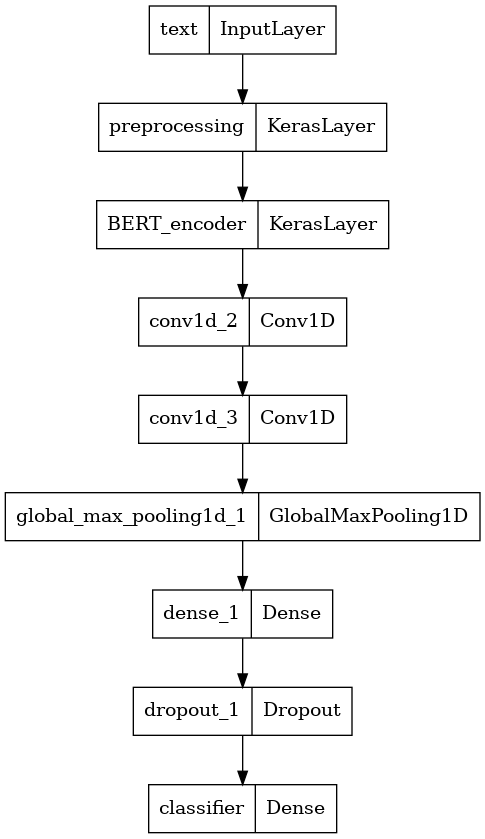

In [38]:
tf.keras.utils.plot_model(cnn_classifier_model)

In [35]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

cnn_classifier_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))

In [30]:
print(f'Training model with {tfhub_handle_encoder}')
cnn_history = cnn_classifier_model.fit(x=train_ds,
                                       validation_data=val_ds,
                                       epochs=epochs)
                                       

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5586: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "sparse_categorical_crossentropy"


1150/1150 [==============================] - 243s 205ms/step - loss: 0.5259 - accuracy: 0.7073 - val_loss: 0.4030 - val_accuracy: 0.8019
Epoch 2/10
1150/1150 [==============================] - 228s 198ms/step - loss: 0.3524 - accuracy: 0.8378 - val_loss: 0.3328 - val_accuracy: 0.8496
Epoch 3/10
1150/1150 [==============================] - 231s 201ms/step - loss: 0.2674 - accuracy: 0.8840 - val_loss: 0.3028 - val_accuracy: 0.8663
Epoch 4/10
1150/1150 [==============================] - 226s 197ms/step - loss: 0.2069 - accuracy: 0.9140 - val_loss: 0.3306 - val_accuracy: 0.8656
Epoch 5/10
1150/1150 [==============================] - 226s 196ms/step - loss: 0.1615 - accuracy: 0.9359 - val_loss: 0.3615 - val_accuracy: 0.8707
Epoch 6/10
1150/1150 [==============================] - 227s 197ms/step - loss: 0.1259 - accuracy: 0.9509 - val_loss: 0.4111 - val_accuracy: 0.8732
Epoch 7/10
1150/1150 [==============================] - 226s 196ms/step - loss: 0.0987 - accuracy: 0.9636 - val_loss: 0.480

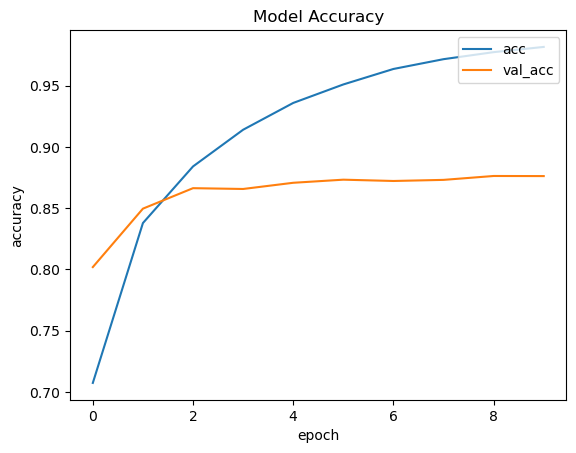

In [31]:
# Train vs Test Acc.
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper right')
plt.show()

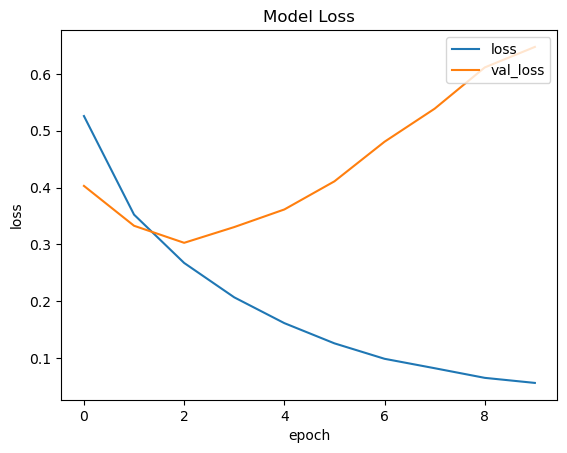

In [32]:
# Train vs Test Loss.
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()